In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import time
import csv
import matplotlib.pyplot as plt

# EDA

In [12]:
X_train = np.load('./data/training_x_grid.npy')
X_test = np.load('./data/testing_x_grid.npy')
y_train = np.load('./data/training_y.npy')

In [13]:
#training: (number of observation, height, width, feature)
number_of_features = X_train.shape[3]
print(X_train.shape, X_test.shape)
print(y_train.shape)

(8760, 30, 38, 13) (8760, 30, 38, 13)
(8760, 2)


In [113]:
#change dimension to (number of observation, channel(feature), height, weight)
# X_train = np.moveaxis(X_train, -1, 1)
# X_test = np.moveaxis(X_test, -1, 1)
# print(X_train.shape)
# print(X_test.shape)

(8760, 13, 30, 38)
(8760, 13, 30, 38)


(30, 38)


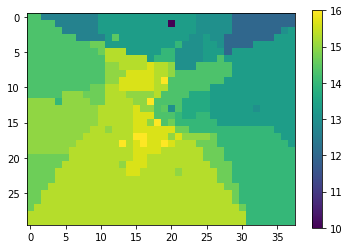

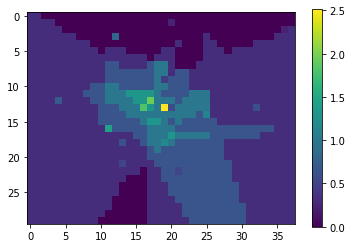

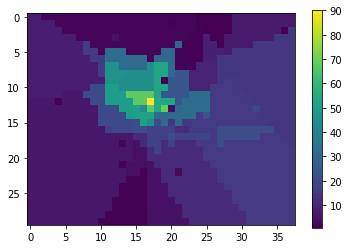

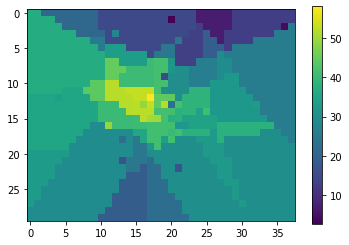

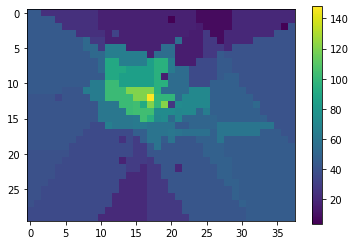

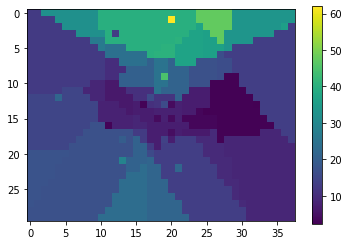

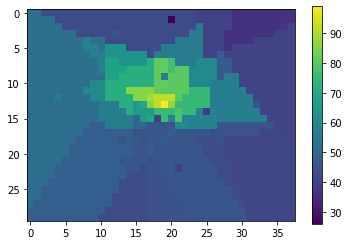

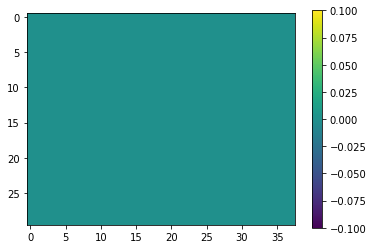

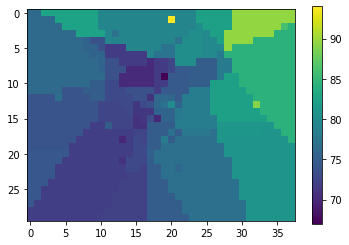

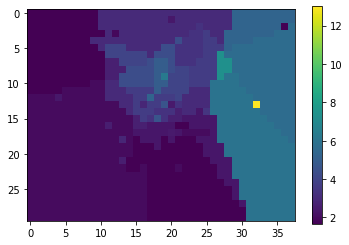

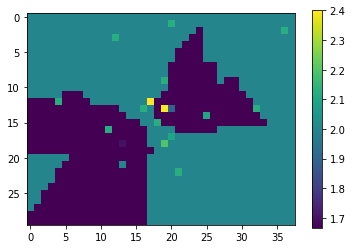

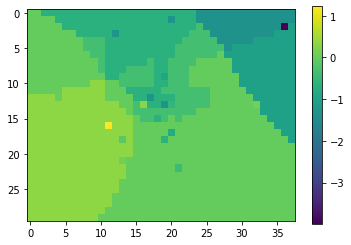

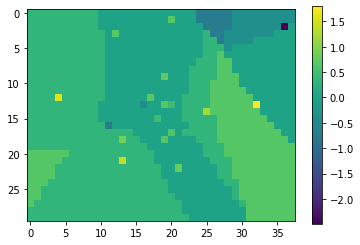

In [18]:
features = 0 #AMB_TEMP, CO, NO, NO2, NOx, O3, PM10, RAINFALL, RH, SO2, THC, cos_wind, sin_wind
image_shape = X_train[0,:,:,0].shape
print(image_shape)
for i in range(number_of_features):
    plt.imshow(X_train[0,:,:,i])
    plt.colorbar()
    plt.show()

# CNN

In [14]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
SEED = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

## Photo preprocessing

In [15]:
mean_img = np.mean(X_train, axis=(0, 1, 2))
std_img = np.std(X_train, axis=(0, 1, 2))
print(f"Mean of each channel is {mean_img}")
print(f"Std of each channel is {std_img}")

Mean of each channel is [ 2.29940176e+01  1.16575642e-01  7.47829880e+00  1.76970715e+01
  2.55730540e+01  2.92185379e+01  4.23096844e+01  2.14363958e-01
  7.50016315e+01  2.81763435e+00  1.28958399e+00 -9.03108535e-03
  7.08277692e-01]
Std of each channel is [ 6.05780731  0.28256565 11.65424577 10.31597383 19.30278588 18.0803279
 22.73653019  1.42130498 12.38884299  2.22243181  0.39840187  0.7309027
  1.29507284]


## Build Dataset and Dataloader

In [16]:
class WeatherTrainingDataset(Dataset):
    def __init__(self, X, y, augment = None):
        self.X = X
        self.y = y
        self.augment = augment
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.augment is not None:
            img = self.augment(self.X[idx])
        else:
            img = self.X[idx]
        label = self.y[idx]
        return img, label

class WeatherTestingDataset(Dataset):
    def __init__(self, X, augment = None):
        self.X = X
        self.augment = augment
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.augment is not None:
            img = self.augment(self.X[idx])
        else:
            img = self.X[idx]
        return img

## Model testing

In [7]:
test_torch = torch.from_numpy(X_train[:1, :, :, :]).to(torch.float32)

In [126]:
print(f"original size: {test_torch.shape}")
conv1 = nn.Conv2d(13, 64, kernel_size=5, padding=2)
out = conv1(test_torch)
print(f"size after conv1: {out.shape}")
conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
max2 = nn.MaxPool2d(2)
out = max2(conv2(out))
print(f"size after conv2: {out.shape}")
conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
max3 = nn.MaxPool2d(2)
out = max3(conv3(out))
print(f"size after conv3: {out.shape}")
conv4 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
max4 = nn.MaxPool2d(2)
out = max4(conv4(out))
print(f"size after conv4: {out.shape}")

original size: torch.Size([1, 13, 30, 38])
size after conv1: torch.Size([1, 64, 30, 38])
size after conv2: torch.Size([1, 64, 15, 19])
size after conv3: torch.Size([1, 128, 7, 9])
size after conv4: torch.Size([1, 512, 3, 4])


In [8]:
loss_fn = torch.nn.MSELoss()
y_pred = torch.from_numpy(np.array([20, 20]))
y_true = torch.from_numpy(y_train[0])
loss_fn(y_pred, y_true)

tensor(512.5000, dtype=torch.float64)

In [17]:
class WeatherRegrssionNet(nn.Module):
    def __init__(self):
        super(WeatherRegrssionNet, self).__init__()

        ###########################general information###########################
        self.conv1_out_channels = 64
        self.leakyReLU1_slope = 0.05
        self.conv1_dropout_rate = 0.2

        self.conv0 = nn.Sequential(
            nn.Conv2d(13, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.Dropout2d(0.2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        #########################location information######################
        self.conv2_out_channels = 512
        self.leakyReLU2_slope = 0.05
        self.conv2_dropout_rate = 0.5
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, self.conv2_out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        #######################Fully connected layer########################
        self.fc1 = nn.Sequential(
            nn.Linear(3*4*self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.4)
        )
        self.fc3 = nn.Linear(self.conv2_out_channels, 2)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 3*4*self.conv2_out_channels)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [18]:
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()            
        optimizer.step()
        train_loss.append(loss.item())
        #release memory
        del img, label, output, loss
        torch.cuda.empty_cache()
    train_loss = np.mean(train_loss)
    return train_loss
    
    
def valid(valid_loader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        for (img, label) in valid_loader:
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            valid_loss.append(loss.item())
            #release memory
            del img, label, output, loss
            torch.cuda.empty_cache()
    #average over all batches
    valid_loss = np.mean(valid_loss)
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

In [19]:
image_transforms = {'train':transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                     ]),
            'valid': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                    ]),
            'test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_img, std=std_img)
                ])
            }

test_ratio = 0.25
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(X_train, y_train, test_size = test_ratio)
train_dataset_CNN = WeatherTrainingDataset(X_train_CNN, y_train_CNN, image_transforms["train"])
valid_dataset_CNN = WeatherTrainingDataset(X_valid_CNN, y_valid_CNN, image_transforms["valid"])
test_dataset_CNN = WeatherTestingDataset(X_test, image_transforms["test"])

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model = WeatherRegrssionNet().float()
model.apply(init_weights)
model.to(device)
model = model.double()

#tunning
optimizer_name = "Adam"
lr = 0.001
batch_size = 128

optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

num_epoch = 200

#build data loader
train_loader_CNN = DataLoader(train_dataset_CNN, batch_size=batch_size, shuffle=True)
valid_loader_CNN = DataLoader(valid_dataset_CNN, batch_size=batch_size, shuffle=False)      

#record
loss_record = []
best_valid_acc = 0
best_valid_loss = 999999
best_epoch = 0
best_model = None

no_update_cnt = 0
patience = 5
x = time.time()
for epoch in range(num_epoch):

    train_loss = train(train_loader_CNN, model, loss_fn, optimizer, device)
    valid_loss = valid(valid_loader_CNN, model, loss_fn, device)
    loss_record.append(valid_loss)
    if valid_loss > best_valid_acc:
        best_model = model
        best_valid_loss = valid_loss
        best_epoch = epoch
        no_update_cnt = 0
    else:
        no_update_cnt += 1
    y = time.time()
    time_train = (y - x) / 60
    print(f"Epoch {epoch}: {round(time_train, 2)} min elapsed, train loss: {round(train_loss , 4)} valid loss: {round(valid_loss, 4)}")
    gc.collect()
    torch.cuda.empty_cache()
    #Early stop
    if no_update_cnt > patience:
        break

print('########################################################')
print("Finish model tuning")
print(f"Best epoch is {best_epoch}, Loss: {best_valid_loss}")
print('########################################################')

Epoch 0: 0.22 min elapsed, train loss: 545.8677 valid loss: 483.2531
Epoch 1: 0.43 min elapsed, train loss: 450.7575 valid loss: 354.6793
Epoch 2: 0.64 min elapsed, train loss: 307.2174 valid loss: 193.5162
Epoch 3: 0.85 min elapsed, train loss: 148.2134 valid loss: 73.7937
Epoch 4: 1.06 min elapsed, train loss: 77.7672 valid loss: 56.4614
Epoch 5: 1.28 min elapsed, train loss: 65.7436 valid loss: 43.2055
Epoch 6: 1.49 min elapsed, train loss: 63.4457 valid loss: 41.7043
Epoch 7: 1.7 min elapsed, train loss: 61.6834 valid loss: 44.0383
Epoch 8: 1.91 min elapsed, train loss: 60.5155 valid loss: 40.4776
Epoch 9: 2.13 min elapsed, train loss: 59.1939 valid loss: 39.076
Epoch 10: 2.34 min elapsed, train loss: 57.5104 valid loss: 39.1912
Epoch 11: 2.55 min elapsed, train loss: 58.7116 valid loss: 40.4205
Epoch 12: 2.76 min elapsed, train loss: 59.2848 valid loss: 39.4681
Epoch 13: 2.98 min elapsed, train loss: 58.6484 valid loss: 41.4711
Epoch 14: 3.19 min elapsed, train loss: 56.3265 valid

In [21]:
def predict(data_loader, model, device, isValid = False, isTesting = False):
    model.eval()
    with torch.no_grad():
        predict_result = []
        if isValid:
            for (img, label) in data_loader:
                img = img.to(device)
                output = model(img).cpu().detach().numpy()
                predict_result.extend(output)
        if isTesting:
            for img in data_loader:
                img = img.to(device)
                output = model(img).cpu().detach().numpy()
                predict_result.extend(output)
    return predict_result

In [22]:
def write_to_csv(predict_result, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['INDEX', 'PM2.5-1', 'PM2.5-2'])
        for i in range(len(predict_result)):
            writer.writerow([str(i+1), str(predict_result[i][0]), str(predict_result[i][1])])

In [16]:
model_path = "./model/1118_model.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)
test_loader = DataLoader(test_dataset_CNN, batch_size=batch_size, shuffle=False) 
y_pred = predict(test_loader, best_model, device, isTesting = True)

In [17]:
time_step = 8
write_to_csv(y_pred[time_step:], './submission/1118_2.csv')

# RNN

## Validating CNN output result

In [23]:
model_path = "./model/1118_model.pth"
checkpoint = torch.load(model_path)
best_model = WeatherRegrssionNet()
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.to(device)
best_model = best_model.double()

In [24]:
batch_size = 128
train_dataset = WeatherTrainingDataset(X_train, y_train, image_transforms["train"])
data_loader_CNN = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
y_pred_train = predict(data_loader_CNN, best_model, device, isValid = True)
y_pred_train = np.array(y_pred_train)

In [25]:
loss_fn = torch.nn.MSELoss()
pred_train_loss = loss_fn(torch.from_numpy(y_pred_train), torch.from_numpy(y_train))
print(f"RMSE of all training dataset is {pred_train_loss}")

RMSE of all training dataset is 22.38445467038281


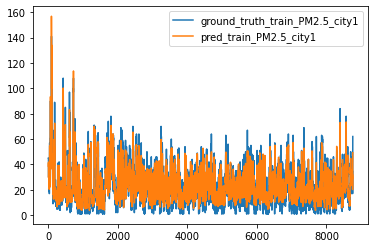

In [21]:
x = [i for i in range(len(y_pred_train))]
plt.plot(x, y_train[:, 0])
plt.plot(x, y_pred_train[:, 0])
plt.legend(["ground_truth_train_PM2.5_city1","pred_train_PM2.5_city1"])
plt.show()

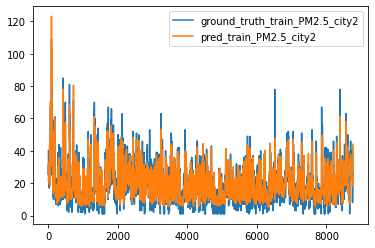

In [22]:
x = [i for i in range(len(y_pred_train))]
plt.plot(x, y_train[:, 1])
plt.plot(x, y_pred_train[:, 1])
plt.legend(["ground_truth_train_PM2.5_city2","pred_train_PM2.5_city2"])
plt.show()

## Data preprocessing

In [26]:
test_loader_CNN = DataLoader(test_dataset_CNN, batch_size=batch_size, shuffle=False) 
y_pred_test = predict(test_loader_CNN, best_model, device, isTesting = True)

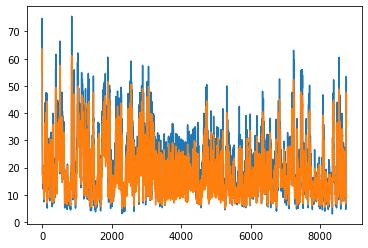

In [25]:
x = [i for i in range(len(y_pred_test))]
plt.plot(x, y_pred_test)
plt.show()

In [27]:
SS = StandardScaler()
y_pred_train_SS = SS.fit_transform(y_pred_train)
y_pred_test_SS = SS.transform(y_pred_test)

In [28]:
time_step = 8
X_train_RNN, X_test_RNN = ([] for _ in range(2))

for i in range(y_pred_train_SS.shape[0]-time_step):
    X_train_RNN.append(y_pred_train_SS[i:i+time_step])
    X_test_RNN.append(y_pred_test_SS[i:i+time_step])
X_train_RNN = np.array(X_train_RNN)
X_test_RNN  = np.array(X_test_RNN)
y_train_RNN = y_train[time_step:] #(8760,2) - > (8752,2)
    
print(X_train_RNN.shape, X_test_RNN.shape) #(8752,8,2)
print(y_train_RNN.shape)

(8752, 8, 2) (8752, 8, 2)
(8752, 2)


In [29]:
class WeatherTrainingRNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

class WeatherTestingRNNDataset(Dataset):
    def __init__(self, X):
        self.X = X
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        return X

In [30]:
#Data set
test_ratio = 0.25
X_train_RNN, X_valid_RNN, y_train_RNN, y_valid_RNN = train_test_split(X_train_RNN, y_train_RNN, test_size = test_ratio)
train_dataset_RNN = WeatherTrainingRNNDataset(X_train_RNN, y_train_RNN)
valid_dataset_RNN = WeatherTrainingRNNDataset(X_valid_RNN, y_valid_RNN)
test_dataset_RNN = WeatherTestingRNNDataset(X_test_RNN)
#Data loader
batch_size = 128
train_loader_RNN = DataLoader(train_dataset_RNN, batch_size=batch_size, shuffle=True)
valid_loader_RNN = DataLoader(valid_dataset_RNN, batch_size=batch_size, shuffle=False)  
test_loader_RNN = DataLoader(test_dataset_RNN, batch_size=batch_size, shuffle=False)  

## Modeling

In [31]:
class WeatherLstmNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(WeatherLstmNet, self).__init__()
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout = 0.3)

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.3)
        )

        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        #(D x num_layers, N, hidden_size)
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device).double()
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device).double()
            
        # Propagate input through LSTM
        #out: (seq_length, batch, D)
        #h_out: (num_layers, batch_size, hidden_size​)
        out, (h_out, c_out) = self.lstm(x, (h_0, c_0)) 
        out = out[:, -1, :] #(batch_size, hidden_size x D)

        #use hidden layer to predict output
        #h_out = h_out.view(-1, self.hidden_size) #(num_layers x batch_size, hidden_size)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [32]:
input_size = 2 #number of features
hidden_size = 512 #number of weight in hidden layer
num_layers = 2 #number of stacked LSTM layer

model_lstm = WeatherLstmNet(input_size, hidden_size, num_layers)
model_lstm.apply(init_weights)
model_lstm.to(device)
model_lstm = model_lstm.double()

#tunning
optimizer_name = "Adam"
lr = 0.005
batch_size = 512
optimizer = getattr(optim, optimizer_name)(model_lstm.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

num_epoch = 500
no_update_cnt = 0
patience = 10

#record
loss_record = []
best_valid_acc = 0
best_valid_loss = 999999
best_epoch = 0
best_model_lstm = None

x = time.time()
for epoch in range(num_epoch):

    train_loss = train(train_loader_RNN, model_lstm, loss_fn, optimizer, device)
    valid_loss = valid(valid_loader_RNN, model_lstm, loss_fn, device)
    loss_record.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_model_lstm = model_lstm
        best_valid_loss = valid_loss
        best_epoch = epoch
        no_update_cnt = 0
    else:
        no_update_cnt += 1
    y = time.time()
    time_train = (y - x) / 60
    print(f"Epoch {epoch}: {round(time_train, 2)} min elapsed, train loss: {round(train_loss , 4)} valid loss: {round(valid_loss, 4)}")
    gc.collect()
    torch.cuda.empty_cache()
    #Early stop
    if no_update_cnt > patience:
        break

print('########################################################')
print("Finish model tuning")
print(f"Best epoch is {best_epoch}, Loss: {best_valid_loss}")
print('########################################################')

Epoch 0: 0.02 min elapsed, train loss: 344.3936 valid loss: 111.6177
Epoch 1: 0.05 min elapsed, train loss: 42.4378 valid loss: 61.4334
Epoch 2: 0.07 min elapsed, train loss: 39.1155 valid loss: 47.1203
Epoch 3: 0.1 min elapsed, train loss: 38.0118 valid loss: 32.2089
Epoch 4: 0.12 min elapsed, train loss: 37.5195 valid loss: 39.1396
Epoch 5: 0.15 min elapsed, train loss: 37.2377 valid loss: 33.9254
Epoch 6: 0.17 min elapsed, train loss: 36.2506 valid loss: 30.5569
Epoch 7: 0.2 min elapsed, train loss: 36.3654 valid loss: 33.0646
Epoch 8: 0.22 min elapsed, train loss: 36.2195 valid loss: 39.1266
Epoch 9: 0.25 min elapsed, train loss: 35.7783 valid loss: 34.3311
Epoch 10: 0.27 min elapsed, train loss: 34.3939 valid loss: 30.451
Epoch 11: 0.29 min elapsed, train loss: 34.4703 valid loss: 30.5425
Epoch 12: 0.31 min elapsed, train loss: 35.0585 valid loss: 54.1429
Epoch 13: 0.34 min elapsed, train loss: 35.1408 valid loss: 35.6221
Epoch 14: 0.36 min elapsed, train loss: 34.9275 valid loss:

In [33]:
y_pred_RNN = predict(test_loader_RNN, best_model_lstm, device, isTesting = True)
write_to_csv(y_pred_RNN, './submission/1118_12_lstm.csv')

In [ ]:
model_path = "./model/best_RNN2.pth"
torch.save({
            'model_state_dict': best_model_lstm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)

# Record
- hidden_size = 64, num_layers = 1, 2FC, lr = 0.005, BS = 128 : valid = 28.7376
- hidden_size = 64, num_layers = 2, 2FC, lr = 0.005, BS = 128 : valid = 31.9497
- hidden_size = 64, num_layers = 2, 2FC, lr = 0.01, BS = 128 : valid = 168.25477
- hidden_size = 64, num_layers = 2, 2FC, lr = 0.01, BS = 256 : valid = 32.2457
- hidden_size = 64, num_layers = 2, 2FC, lr = 0.01, BS = 512 : valid = 32.422
- hidden_size = 64, num_layers = 2, 2FC, lr = 0.01, BS = 512 : valid = 31.95474
- hidden_size = 64, num_layers = 2, 2FC + dropout, lr = 0.01, BS = 512 : valid = 30.2822
- hidden_size = 64, num_layers = 2 + dropout, 2FC + dropout, lr = 0.01, BS = 512 : valid = 32.78
- hidden_size = 64, num_layers = 2 + dropout, 2FC + dropout, lr = 0.01, BS = 512 : valid = 30.065
- hidden_size = 48, num_layers = 2 + dropout, 2FC + dropout, lr = 0.01, BS = 512 : train: 56.9704 valid = 30.0865
- hidden_size = 128, num_layers = 2 + dropout 0. 5, 2FC + dropout 0.5, lr = 0.01, BS = 512 : train: 40.7603 valid = 29.866
- hidden_size = 512, num_layers = 2 + dropout 0. 5, 2FC + dropout 0.5, lr = 0.01, BS = 512 : train: 40.7603 valid = 29.866 (pass!)